### EDA Analysis

/home/kangh/miniconda3/envs/elt/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Monthly Sales Trends:
    order_year  order_month  total_sales  total_orders
0         2016            9       116.01             3
1         2016           10     51741.69           289
2         2016           12        19.62             1
3         2017            1    127913.95           753
4         2017            2    274125.65          1670
5         2017            3    421826.62          2579
6         2017            4    398894.20          2321
7         2017            5    571455.59          3575
8         2017            6    494199.36          3151
9         2017            7    573455.49          3900
10        2017            8    653172.46          4220
11        2017            9    705151.17          4170
12        2017           10    757713.80          4504
13        2017           11   1161186.49          7326
14        2017           12    846638.42          5524
15        2018            1   1084147.04          7103
16        2018            2    974184.03   

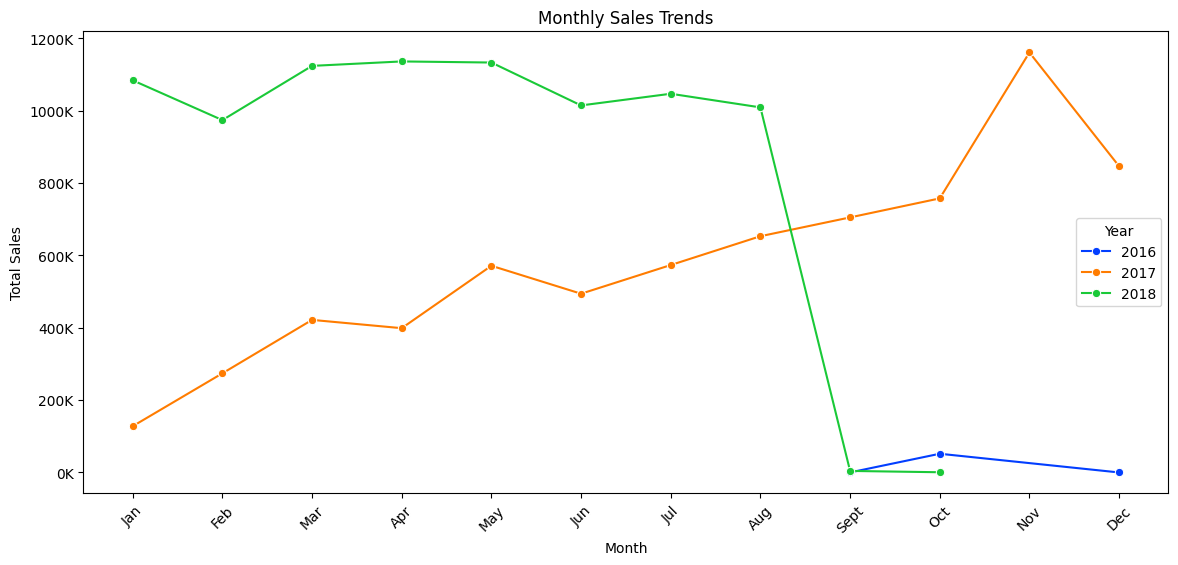

/home/kangh/miniconda3/envs/elt/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Top-selling Products by Category:
    product_category_name  orders_count  total_sales
0            beleza_saude          9501   1236117.93
1      relogios_presentes          5880   1172997.45
2         cama_mesa_banho         10971   1024459.38
3           esporte_lazer          8482    963160.60
4  informatica_acessorios          7690    896356.91
5        moveis_decoracao          8196    714225.13
6              cool_stuff          3734    624659.56
7   utilidades_domesticas          6844    621051.55
8              automotivo          4170    585066.03
9              brinquedos          4064    475424.54


/tmp/ipykernel_1194926/2725802602.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_top_products['product_category_name'], rotation=45, ha='right')


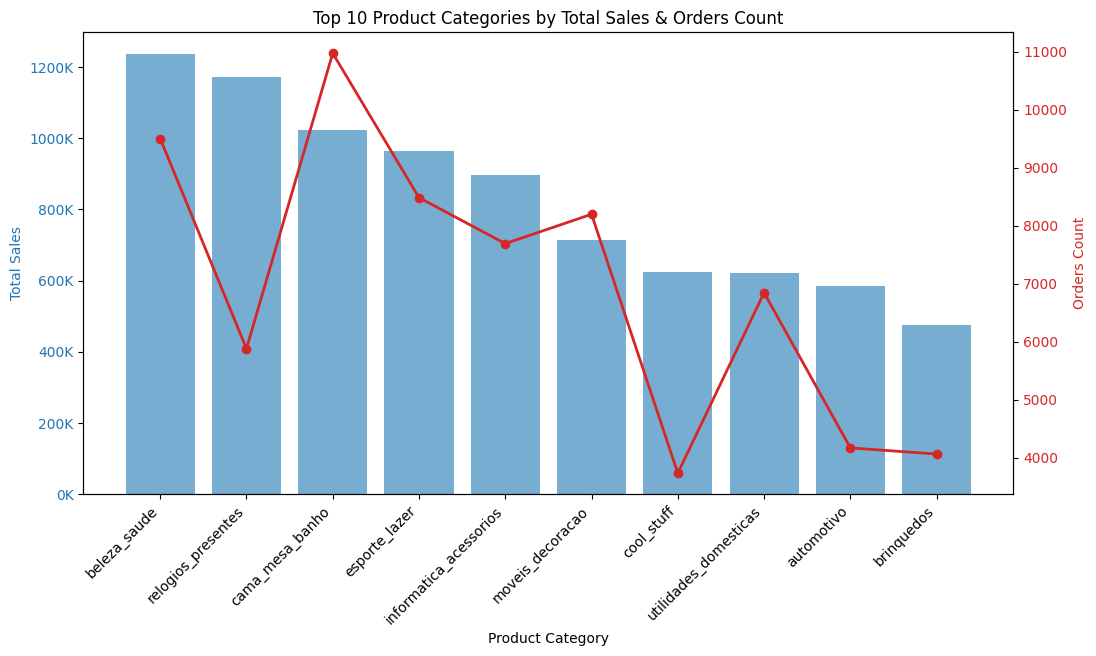

/home/kangh/miniconda3/envs/elt/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Customer Segmentation by Purchase Behavior (by City):
            customer_city  total_orders  total_sales  avg_order_value
0               sao paulo         15185   2132135.89           140.41
1          rio de janeiro          6649   1120562.64           168.53
2          belo horizonte          2714    411738.40           151.71
3                brasilia          2078    347644.91           167.30
4                curitiba          1499    244363.51           163.02
5            porto alegre          1347    218924.45           162.53
6                campinas          1417    210448.16           148.52
7                salvador          1192    208288.06           174.74
8               guarulhos          1157    159835.54           138.15
9                 niteroi           829    136452.94           164.60
10                goiania           667    120950.08           181.33
11  sao bernardo do campo           919    117521.69           127.88
12              fortaleza           

/tmp/ipykernel_1194926/2725802602.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_customer_segmentation, x="customer_city", y="total_sales", palette="rocket")


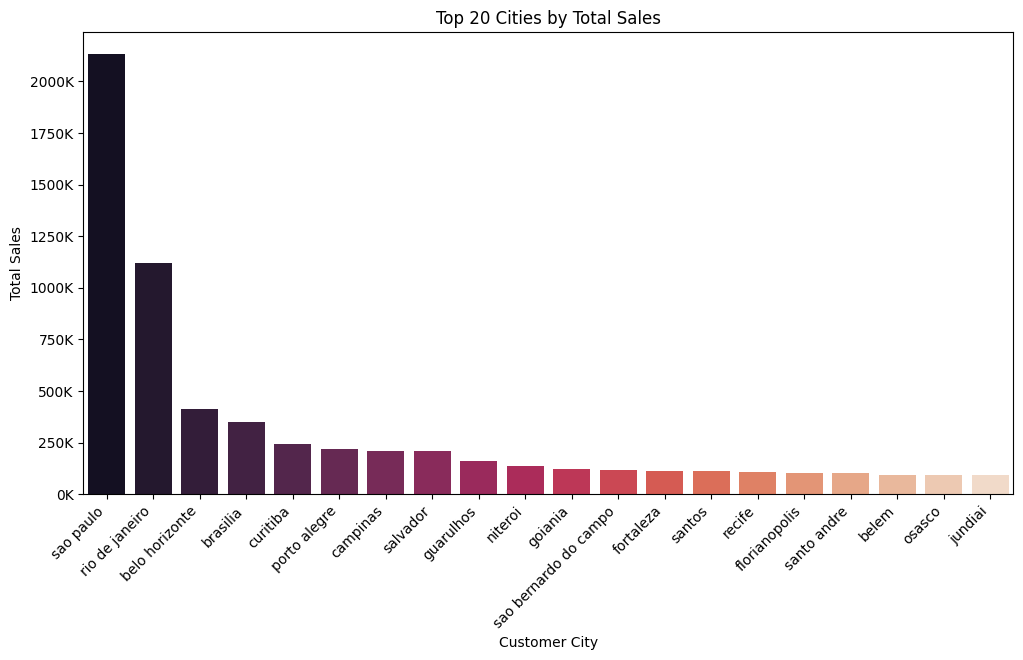

In [2]:
# Import necessary libraries
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import matplotlib.ticker as mtick

# Set up BigQuery client (ensure your environment is authenticated)
project_id = "olist-ecommerce-454812"  # update as needed
client = bigquery.Client(project=project_id)

# # 1. Monthly Sales Trends
query_monthly_sales = f"""
SELECT
  EXTRACT(YEAR FROM CAST(order_purchase_timestamp AS TIMESTAMP)) AS order_year,
  EXTRACT(MONTH FROM CAST(order_purchase_timestamp AS TIMESTAMP)) AS order_month,
  SUM(payment_value) AS total_sales,
  COUNT(DISTINCT order_id) AS total_orders
FROM `olist-ecommerce-454812.olist_data_ingestion_fact_tables.fact_orders`
GROUP BY order_year, order_month
ORDER BY order_year, order_month
"""

df_monthly_sales = client.query(query_monthly_sales).to_dataframe()
print("Monthly Sales Trends:")
print(df_monthly_sales)

# Get unique month numbers sorted from the DataFrame
unique_months = sorted(df_monthly_sales['order_month'].unique())

# Create abbreviated month labels, replacing 'Sep' with 'Sept' if desired
month_labels = [("Sept" if int(x) == 9 else calendar.month_abbr[int(x)]) for x in unique_months]

# month_labels = [calendar.month_name[int(x)] for x in unique_months]

# Plotting Monthly Sales Trends
plt.figure(figsize=(14,6))
# Plot with x-axis as the numeric month
sns.lineplot(
    data=df_monthly_sales.sort_values('order_month'),
    x="order_month",
    y="total_sales",
    hue="order_year",
    marker="o",
    palette="bright"
)
# Set the x-axis ticks to be the month numbers and label them with month names.
plt.xticks(ticks=unique_months, labels=month_labels, rotation=45)
plt.title("Monthly Sales Trends")
plt.xlabel("Month")
plt.ylabel("Total Sales")
# Format y-axis ticks to display values in thousands (e.g., 150K)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))
plt.legend(title="Year")
plt.show()


# 2. Top-selling Products
query_top_products = f"""
SELECT
  product_category_name,
  COUNT(order_id) AS orders_count,
  SUM(price) AS total_sales
FROM `olist-ecommerce-454812.olist_data_ingestion_fact_tables.fact_order_items` A
INNER JOIN `olist-ecommerce-454812.olist_data_ingestion_dim_tables.dim_product` B 
  ON B.product_id = A.product_id
GROUP BY product_category_name
ORDER BY total_sales DESC
LIMIT 10
"""

df_top_products = client.query(query_top_products).to_dataframe()
print("Top-selling Products by Category:")
print(df_top_products)

# Create a dual-axis chart
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot total_sales as bars on primary y-axis
color1 = 'tab:blue'
ax1.set_xlabel("Product Category")
ax1.set_ylabel("Total Sales", color=color1)
bars = ax1.bar(df_top_products['product_category_name'], df_top_products['total_sales'], color=color1, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))
ax1.set_xticklabels(df_top_products['product_category_name'], rotation=45, ha='right')

# Create a secondary y-axis for orders_count
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel("Orders Count", color=color2)
line = ax2.plot(df_top_products['product_category_name'], df_top_products['orders_count'], color=color2, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Top 10 Product Categories by Total Sales & Orders Count")
plt.show()

# 3. Customer Segmentation by Purchase Behavior by City
# Calculate total orders, total sales and average order value per customer_city.

query_customer_segmentation = f"""
SELECT
  B.customer_city,
  COUNT(order_id) AS total_orders,
  SUM(payment_value) AS total_sales,
  ROUND(AVG(payment_value),2) AS avg_order_value
FROM `olist-ecommerce-454812.olist_data_ingestion_fact_tables.fact_orders` A
INNER JOIN `olist-ecommerce-454812.olist_data_ingestion_dim_tables.dim_customer` B ON B.customer_id = A.customer_id
GROUP BY B.customer_city
ORDER BY total_sales DESC
LIMIT 20
"""

df_customer_segmentation = client.query(query_customer_segmentation).to_dataframe()
print("Customer Segmentation by Purchase Behavior (by City):")
print(df_customer_segmentation)

# Plotting Customer Segmentation (Top 20 Cities by Total Sales)
plt.figure(figsize=(12,6))
sns.barplot(data=df_customer_segmentation, x="customer_city", y="total_sales", palette="rocket")
plt.title("Top 20 Cities by Total Sales")
plt.xlabel("Customer City")
plt.ylabel("Total Sales")
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))
plt.show()
